In [2]:
import pint
class ScmUnitRegistry(pint.UnitRegistry):  # type: ignore
    """
    Unit registry class for OpenSCM. Provides some convenience methods to add standard
    unit and contexts.
    """

    _contexts_loaded = False

    def add_standards(self):
        """
        Add standard units.
        Has to be done separately because of pint's weird initializing.
        """
#        self._add_gases(_standard_gases)

        self.define("a = 1 * year = annum = yr")
        self.define("h = hour")
        self.define("d = day")
#        self.define("degreeC = degC")
#        self.define("degreeF = degF")
        self.define("kt = 1000 * t")  # since kt is used for "knot" in the defaults
    
        self.define('volume_mixing_ratio = [vmr] = vmr')
        self.define('parts_per_million = 1e-6 * volume_mixing_ratio = ppm')
        self.define('parts_per_billion = 1e-9 * volume_mixing_ratio = ppb')
        self.define('parts_per_trillion = 1e-12 * volume_mixing_ratio = ppt')

In [3]:
# from openscm.units import _unit_registry as unit
# #unit = ScmUnitRegistry()
# kt = unit("kt")
# unit('kt')

In [4]:
import numpy as np
from fair.constants.general import M_ATMOS
from fair.constants.molwt import AIR as M_AIR   # this will be moved
from fair.constants import molwt
import pint

unit = pint.UnitRegistry()
#unit.add_standards()
unit.define('volume_mixing_ratio = [vmr] = vmr')
unit.define('percent = 0.01 * volume_mixing_ratio = pc')
unit.define('parts_per_million = 1e-6 * volume_mixing_ratio = ppm')
unit.define('parts_per_billion = 1e-9 * volume_mixing_ratio = ppb')
unit.define('parts_per_trillion = 1e-12 * volume_mixing_ratio = ppt')
unit.define('kt = 1000 * t')
unit.define('kilometric_ton = kt')
emissions = 10 * unit.kt / unit.year
M_ATM = M_ATMOS * unit.kg
m_ch4 = molwt.CH4 * unit.g / unit.mol
M_AIR = molwt.AIR * unit.g / unit.mol
timestep = 1 * unit.year

print(emissions)
print(M_ATM)
print(m_ch4, M_AIR)

# this is per year
print((emissions/M_ATM * M_AIR/m_ch4 * unit.year * unit.vmr).to_base_units().to('ppb'))

10.0 kt / year
5.1352e+18 kilogram
16.04 gram / mole 28.97 gram / mole
0.0035171166180203023 parts_per_billion


In [65]:
library = ['CO2', 'CH4', 'N2O']

class Species:
 
    def __init__(self, radiative_efficiency, reference_concentration, concentration_t0, molecular_weight, name=None, efficacy=1):
        self.name = name
        self.efficacy = efficacy
        self.radiative_efficiency    = radiative_efficiency
        self.reference_concentration = reference_concentration
        self.concentration_t0        = concentration_t0
        self.molecular_weight        = molecular_weight
        self.kg_to_vmr               = M_AIR/self.molecular_weight / M_ATM * 1.0 * unit.vmr        
        #if name in library:   # pandas datatable of stats or a csv?
            # load up all the stuff above
            # self.lifetime = library[name].lifetime
            # self.radiative_efficiency = library[name].radiative_efficiency and so on
    
    def set_emissions(self, anthropogenic, natural=0, timestep=unit.year):
        self.emissions = anthropogenic
        self.natural_emissions = natural
        self.timestep = timestep
        return Emissions(anthropogenic, natural, timestep)
    
    def set_concentrations(self, concentrations):
        self.concentrations = concentrations
        return Concentrations(concentrations)
        
    def set_lifetime(self, lifetime):
        self.lifetime = lifetime
        
    def calculate_concentrations(self):
        # for GHGs with no temperature feedback or inter-species dependence
        emissions = self.emissions + self.natural_emissions
        nt = len(emissions)   # ensures that either emissions or natural_emissions are array - still need to check it is 1D
        concentrations = np.ones(nt+1) * np.nan * unit.vmr

        def _forward(c0, em, ts, lt, vm):   # put this in its own module and import
            c1 = c0*np.exp(-ts/lt) + lt*em*vm * (1.-np.exp(-ts/lt))
            return c1
            
        concentrations[0] = self.concentration_t0
        
        for t in range(nt):
            concentrations[t+1] = _forward(concentrations[t], emissions[t], 
                                         timestep, self.lifetime, self.kg_to_vmr)

        self.concentrations = concentrations
        return Concentrations(concentrations)

    def calculate_forcing(self, scale=1):
        # need checks to determine that scale is scalar or array with same length as 
        if self.name in ['carbon dioxide','methane','nitrous oxide']:   # see how we used the init param here
            print('Etminan routine TBC')
            self.effective_radiative_forcing = -9999
        else:
            self.effective_radiative_forcing = (self.concentrations - self.reference_concentration) * self.radiative_efficiency * scale
            self.effective_radiative_forcing.ito(unit.watt / unit.m**2)
        return EffectiveRadiativeForcing(self.effective_radiative_forcing)

    
class GreenhouseGas(Species):
#    def __init__(self):
    pass
#        self.name                    = Species.name
    
        
class Emissions:
    def __init__(self, anthropogenic, natural, timestep):
        self.emissions=anthropogenic
        self.natural_emissions=natural
        self.timestep=timestep
        
        
class Concentrations:
    def __init__(self, concentrations):
        self.concentrations = concentrations
    
    
class EffectiveRadiativeForcing:
    def __init__(self, effective_radiative_forcing):
        self.effective_radiative_forcing = effective_radiative_forcing
        
        
class Temperature:
    def __init__(self):
        pass

In [66]:
CFC12 = GreenhouseGas(radiative_efficiency=0.32 * unit.watt / unit.m**2 / unit.ppb,
                   reference_concentration=0 * unit.ppt,
                   concentration_t0=0 * unit.ppt,
                   molecular_weight=120.91 * unit.g / unit.mol)
CFC12.set_emissions(np.ones(1000)*500 * unit.kt / unit.year,
                  natural = 0.00 * unit.kt / unit.year)
CFC12.set_lifetime(100 * unit.years)
CFC12.calculate_concentrations()

/nfs/see-fs-02_users/mencsm/.local/lib/python3.5/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)


In [67]:
N2O = GreenhouseGas(
    radiative_efficiency=0.32 * unit.watt / unit.m**2 / unit.ppb,
    reference_concentration=273 * unit.ppb,
    concentration_t0 = 273 * unit.ppb,
    molecular_weight = 44.01 * unit.g / unit.mol,
    name='nitrous oxide'
)
N2O.set_concentrations(np.linspace(272,500,801) * unit.ppb)

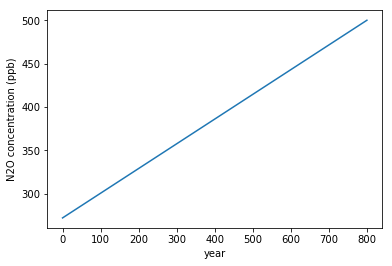

In [68]:
years = np.arange(801) * unit.year
pl.plot(years, N2O.concentrations.to('ppb'))
pl.xlabel('year')
pl.ylabel('N2O concentration (ppb)');

In [69]:
N2O.calculate_forcing()

Etminan routine TBC


In [70]:
kiloton = 1*unit.kt
kiloton.check('[mass]')

True

In [71]:
unit.Mt

<Unit('megametric_ton')>

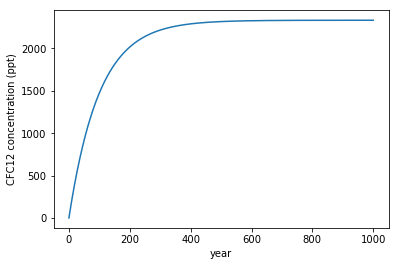

In [72]:
%matplotlib inline
import matplotlib.pyplot as pl
years = np.arange(1001) * unit.year
pl.plot(years, CFC12.concentrations.to('ppt'))
pl.xlabel('year')
pl.ylabel('CFC12 concentration (ppt)');

In [52]:
CFC12.calculate_forcing()

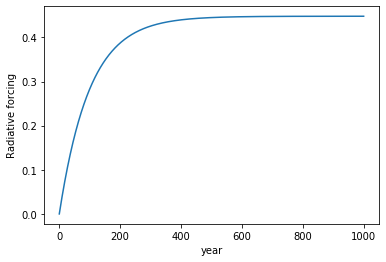

In [8]:
pl.plot(years, CFC12.radiative_forcing.to('W/m**2'))
pl.xlabel('year')
pl.ylabel('Radiative forcing');

Text(0, 0.5, 'temperature')

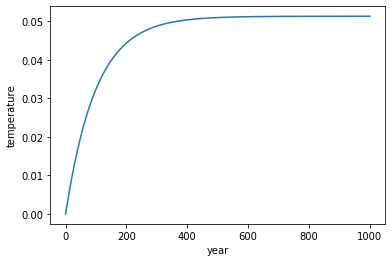

In [9]:
# this I think is currently wrong but has not been followed through fully from fair 1.0 - just illustrative
def calculate_temperature(radiative_forcing,
                          efficacy=1,
                          d=np.array([239, 4.1]) * unit.year,
                          q=np.array([0.33,0.41]) * unit.K * unit.m**2 / unit.watt,
                          timestep = 1 * unit.year
                         ):
    # radiative forcing needs to be smartly handled here
    # radiative_forcing = sum_over_all_species_forcing
    nbox = len(q)
    nt = len(radiative_forcing)
    T_j = np.ones((nt, nbox)) * np.nan * unit.K
    T   = np.ones((nt)) * np.nan * unit.K
    
    # Update the thermal response boxes
    T_j[0,:] = (q/d)*radiative_forcing[0] * efficacy * timestep

    # Sum the thermal response boxes to get the total temperature anomaly
    T[0]=np.sum(T_j[0,:],axis=-1)
    
    for t in range(1,nt):
        # Update the thermal response boxes
        T_j[t,:] = T_j[t-1,:]*(1 - np.exp(-timestep/d)) + q * (1-np.exp((-timestep)/d)) * radiative_forcing[t] * efficacy
        # Sum the thermal response boxes to get the total temperature
        T[t]=np.sum(T_j[t,:],axis=-1)
    return T
        
T = calculate_temperature(CFC12.radiative_forcing)
pl.plot(years, T)
pl.xlabel('year')
pl.ylabel('temperature')

In [25]:
import pint
ureg = pint.UnitRegistry()
del ureg.knot

AttributeError: knot

In [26]:
fair.__version__

'1.4+3.g52e1df7.dirty'

In [25]:
import fair

In [22]:
np.linspace(272,500,801) * unit.ppb

array([ 272.   ,  272.285,  272.57 ,  272.855,  273.14 ,  273.425,
        273.71 ,  273.995,  274.28 ,  274.565,  274.85 ,  275.135,
        275.42 ,  275.705,  275.99 ,  276.275,  276.56 ,  276.845,
        277.13 ,  277.415,  277.7  ,  277.985,  278.27 ,  278.555,
        278.84 ,  279.125,  279.41 ,  279.695,  279.98 ,  280.265,
        280.55 ,  280.835,  281.12 ,  281.405,  281.69 ,  281.975,
        282.26 ,  282.545,  282.83 ,  283.115,  283.4  ,  283.685,
        283.97 ,  284.255,  284.54 ,  284.825,  285.11 ,  285.395,
        285.68 ,  285.965,  286.25 ,  286.535,  286.82 ,  287.105,
        287.39 ,  287.675,  287.96 ,  288.245,  288.53 ,  288.815,
        289.1  ,  289.385,  289.67 ,  289.955,  290.24 ,  290.525,
        290.81 ,  291.095,  291.38 ,  291.665,  291.95 ,  292.235,
        292.52 ,  292.805,  293.09 ,  293.375,  293.66 ,  293.945,
        294.23 ,  294.515,  294.8  ,  295.085,  295.37 ,  295.655,
        295.94 ,  296.225,  296.51 ,  296.795,  297.08 ,  297.365,
        297.65 ,  297.935,  298.22 ,  298.505,  298.79 ,  299.075,
        299.36 ,  299.645,  299.93 ,  300.215,  300.5  ,  300.785,
        301.07 ,  301.355,  301.64 ,  301.925,  302.21 ,  302.495,
        302.78 ,  303.065,  303.35 ,  303.635,  303.92 ,  304.205,
        304.49 ,  304.775,  305.06 ,  305.345,  305.63 ,  305.915,
        306.2  ,  306.485,  306.77 ,  307.055,  307.34 ,  307.625,
        307.91 ,  308.195,  308.48 ,  308.765,  309.05 ,  309.335,
        309.62 ,  309.905,  310.19 ,  310.475,  310.76 ,  311.045,
        311.33 ,  311.615,  311.9  ,  312.185,  312.47 ,  312.755,
        313.04 ,  313.325,  313.61 ,  313.895,  314.18 ,  314.465,
        314.75 ,  315.035,  315.32 ,  315.605,  315.89 ,  316.175,
        316.46 ,  316.745,  317.03 ,  317.315,  317.6  ,  317.885,
        318.17 ,  318.455,  318.74 ,  319.025,  319.31 ,  319.595,
        319.88 ,  320.165,  320.45 ,  320.735,  321.02 ,  321.305,
        321.59 ,  321.875,  322.16 ,  322.445,  322.73 ,  323.015,
        323.3  ,  323.585,  323.87 ,  324.155,  324.44 ,  324.725,
        325.01 ,  325.295,  325.58 ,  325.865,  326.15 ,  326.435,
        326.72 ,  327.005,  327.29 ,  327.575,  327.86 ,  328.145,
        328.43 ,  328.715,  329.   ,  329.285,  329.57 ,  329.855,
        330.14 ,  330.425,  330.71 ,  330.995,  331.28 ,  331.565,
        331.85 ,  332.135,  332.42 ,  332.705,  332.99 ,  333.275,
        333.56 ,  333.845,  334.13 ,  334.415,  334.7  ,  334.985,
        335.27 ,  335.555,  335.84 ,  336.125,  336.41 ,  336.695,
        336.98 ,  337.265,  337.55 ,  337.835,  338.12 ,  338.405,
        338.69 ,  338.975,  339.26 ,  339.545,  339.83 ,  340.115,
        340.4  ,  340.685,  340.97 ,  341.255,  341.54 ,  341.825,
        342.11 ,  342.395,  342.68 ,  342.965,  343.25 ,  343.535,
        343.82 ,  344.105,  344.39 ,  344.675,  344.96 ,  345.245,
        345.53 ,  345.815,  346.1  ,  346.385,  346.67 ,  346.955,
        347.24 ,  347.525,  347.81 ,  348.095,  348.38 ,  348.665,
        348.95 ,  349.235,  349.52 ,  349.805,  350.09 ,  350.375,
        350.66 ,  350.945,  351.23 ,  351.515,  351.8  ,  352.085,
        352.37 ,  352.655,  352.94 ,  353.225,  353.51 ,  353.795,
        354.08 ,  354.365,  354.65 ,  354.935,  355.22 ,  355.505,
        355.79 ,  356.075,  356.36 ,  356.645,  356.93 ,  357.215,
        357.5  ,  357.785,  358.07 ,  358.355,  358.64 ,  358.925,
        359.21 ,  359.495,  359.78 ,  360.065,  360.35 ,  360.635,
        360.92 ,  361.205,  361.49 ,  361.775,  362.06 ,  362.345,
        362.63 ,  362.915,  363.2  ,  363.485,  363.77 ,  364.055,
        364.34 ,  364.625,  364.91 ,  365.195,  365.48 ,  365.765,
        366.05 ,  366.335,  366.62 ,  366.905,  367.19 ,  367.475,
        367.76 ,  368.045,  368.33 ,  368.615,  368.9  ,  369.185,
        369.47 ,  369.755,  370.04 ,  370.325,  370.61 ,  370.895,
        371.18 ,  371.465,  371.75 ,  372.035,  372.32 ,  372.605,
        372.89 ,  373.175,  373.46 ,  373.745, 